In [1]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

caltech_dir = "./"
categories = ["corgi", "golden" ,"dach" ,"husky" ,"beagle"] # 각 카테고리 폴더에서 불러오기
nb_classes = len(categories)

image_w = 100
image_h = 100

pixels = image_h * image_w * 3

X = []
y = []

for idx, cat in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 700 == 0:
            print(cat, " : ", f)

X = np.array(X)
y = np.array(y)
#1 0 0 0 이면 airplanes
#0 1 0 0 이면 buddha 이런식


X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("./multi_image_data.npy", xy)

print("ok", len(y))

corgi  파일 길이 :  969
corgi  :  .//corgi\corgi 10.jpg
corgi  :  .//corgi\corgi2909.jpg
golden  파일 길이 :  0
dach  파일 길이 :  527
dach  :  .//dach\dachs.jpg
husky  파일 길이 :  502
husky  :  .//husky\husky1.jpg
beagle  파일 길이 :  0
ok 1998


# 위에서 이미지 4000장 불러오면서 이미지벡터화 시킴.

In [3]:
import scipy
import numpy
import matplotlib
import pandas
import sklearn
#import pydot
import h5py

import tensorflow
import keras

print('scipy ' + scipy.__version__)
print('numpy ' + numpy.__version__)
print('matplotlib ' + matplotlib.__version__)
print('pandas ' + pandas.__version__)
print('sklearn ' + sklearn.__version__)
print('h5py ' + h5py.__version__)
print('tensorflow ' + tensorflow.__version__)
print('keras ' + keras.__version__)

scipy 1.3.2
numpy 1.16.5
matplotlib 3.1.1
pandas 0.25.1
sklearn 0.21.3
h5py 2.9.0
tensorflow 1.14.0
keras 2.3.1


In [ ]:
# 텐서플로우 1.14. 버전에서 구동중

In [4]:
import os, glob, numpy as np
import tensorflow.keras as keras
# module 'tensorflow' has no attribute 'get_default_graph'

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K
from tensorflow.python.framework import ops
ops.reset_default_graph()
import tensorflow as tf
'''
config = tf.ConfigProto()  텐서플로우 2. 에서 구동안됨
module 'tensorflow' has no attribute 'ConfigProto'
'''
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

# session = tf.Session(config=config) 자동세션기능
X_train, X_test, y_train, y_test = np.load('./multi_image_data.npy',allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


(1498, 100, 100, 3)
1498
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 236033812879136833
]


In [5]:
categories = ["corgi", "golden" ,"dach" ,"husky" ,"beagle"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255


In [6]:
with K.tf.device('/device:GPU:0'): # 디바이스 현재 GPU 없이 CPU로 구동중
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_dir = './model'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    model_path = model_dir + '/multi_img_classification.model'
    checkpoint = ModelCheckpoint(filepath=model_path , monitor='test_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='test_loss', patience=6)
    
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 40000)           

In [7]:
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])


Train on 1498 samples, validate on 500 samples
Epoch 1/20
1498/1498 [==============================] - 12s 8ms/step - loss: 0.9319 - accuracy: 0.5574 - val_loss: 0.6343 - val_accuracy: 0.7300
Epoch 2/20


C:\Users\ICT01_01\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with test_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
C:\Users\ICT01_01\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `test_loss` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1498/1498 [==============================] - 12s 8ms/step - loss: 0.6137 - accuracy: 0.7270 - val_loss: 0.5234 - val_accuracy: 0.8120
Epoch 3/20
1498/1498 [==============================] - 12s 8ms/step - loss: 0.4355 - accuracy: 0.8291 - val_loss: 0.4866 - val_accuracy: 0.8080
Epoch 4/20
1498/1498 [==============================] - 12s 8ms/step - loss: 0.3366 - accuracy: 0.8832 - val_loss: 0.3314 - val_accuracy: 0.8720
Epoch 5/20
1498/1498 [==============================] - 12s 8ms/step - loss: 0.2589 - accuracy: 0.8972 - val_loss: 0.3274 - val_accuracy: 0.8780
Epoch 6/20
1498/1498 [==============================] - 12s 8ms/step - loss: 0.2106 - accuracy: 0.9299 - val_loss: 0.2459 - val_accuracy: 0.9100
Epoch 7/20
1498/1498 [==============================] - 12s 8ms/step - loss: 0.1883 - accuracy: 0.9366 - val_loss: 0.2329 - val_accuracy: 0.9120
Epoch 8/20
1498/1498 [==============================] - 12s 8ms/step - loss: 0.1786 - accuracy: 0.9366 - val_loss: 0.2842 - val_accuracy: 0.8

In [8]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

500/500 [==============================] - 1s 1ms/step
정확도 : 0.9220


In [9]:
history.history

{'val_loss': [0.6343297390937805,
  0.5233921947479248,
  0.48656386804580687,
  0.3314125261306763,
  0.32742979216575624,
  0.2458609756231308,
  0.23293709790706635,
  0.2841954312324524,
  0.26716094541549684,
  0.26087410551309587,
  0.2634523009061813,
  0.2484108311533928,
  0.2766524584889412,
  0.3053732231855392,
  0.36267592167854307,
  0.25320189994573594,
  0.6097045559883117,
  0.27223362062871453,
  0.32042760992050173,
  0.271267125159502],
 'val_accuracy': [0.7300000190734863,
  0.8119999766349792,
  0.8080000281333923,
  0.871999979019165,
  0.878000020980835,
  0.9100000262260437,
  0.9120000004768372,
  0.8799999952316284,
  0.8899999856948853,
  0.9120000004768372,
  0.906000018119812,
  0.9200000166893005,
  0.9160000085830688,
  0.9039999842643738,
  0.878000020980835,
  0.9240000247955322,
  0.8740000128746033,
  0.9259999990463257,
  0.9039999842643738,
  0.921999990940094],
 'loss': [0.931870570528173,
  0.6136859928336099,
  0.43550525452489053,
  0.336582177

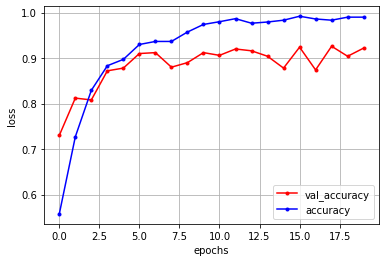

In [11]:
y_vloss = history.history['val_accuracy']
y_loss = history.history['accuracy']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_accuracy')
plt.plot(x_len, y_loss, marker='.', c='blue', label='accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

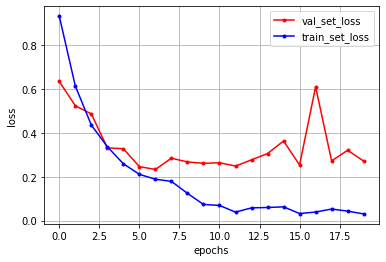

In [13]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [ ]:
# 모델이 너무 과적합 되서 배치정규화로 나아지는지 확인.

# 모델 앙상블하기
https://github.com/KerasKorea/KEKOxTutorial/blob/master/16_Ensembling%20ConvNets%20using%20Keras.md

https://github.com/mmxmb/keras_ensemblng/blob/master/keras_ensembling.ipynb

In [ ]:
# 새로운 모델에 적용하기

In [14]:
from keras.models import Model, Input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Activation, Average
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.callbacks import History
from keras.engine import training
from keras.optimizers import Adam
from typing import Tuple, List

import glob
import numpy as np
from tensorflow.python.framework import ops
ops.reset_default_graph()
import tensorflow as tf
'''
config = tf.ConfigProto()  텐서플로우 2. 에서 구동안됨
module 'tensorflow' has no attribute 'ConfigProto'
'''
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

# session = tf.Session(config=config) 자동세션기능
X_train, X_test, y_train, y_test = np.load('./multi_image_data.npy',allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])

(1498, 100, 100, 3)
1498


In [ ]:
# 현재 작업 폴더 얻기 os.getcwd()
'''
CONV_POOL_CNN_WEIGHT_FILE = os.path.join(os.getcwd(), 'weights', 'conv_pool_cnn_pretrained_weights.hdf5')
ALL_CNN_WEIGHT_FILE = os.path.join(os.getcwd(), 'weights', 'all_cnn_pretrained_weights.hdf5')
NIN_CNN_WEIGHT_FILE = os.path.join(os.getcwd(), 'weights', 'nin_cnn_pretrained_weights.hdf5')
''' 에러나서 현재 못씀

In [15]:
categories = ["corgi", "golden" ,"dach" ,"husky" ,"beagle"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

print('X_train shape: {} | y_train shape: {}\nX_test shape : {} | y_test shape : {}'.format(
    X_train.shape, y_train.shape, X_test.shape, y_test.shape))


#세개의 모델에서 같은 형태의 데이터를 사용할 것, 모든 모델에서 사용할 단일 입력 레이어를 정의.
input_shape =X_train[0,:,:,:].shape
model_input = Input(shape =input_shape)

X_train shape: (1498, 100, 100, 3) | y_train shape: (1498, 5)
X_test shape : (500, 100, 100, 3) | y_test shape : (500, 5)


In [16]:
# 모델보다 작아서 훈련이 훨씬 빠름. 최종 Conv2D
def nin_cnn(model_input):
    
    #mlpconv block 1
    x = Conv2D(32, (3, 3), activation='relu',padding='valid')(model_input)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.5)(x)
    
    #mlpconv block2
    x = Conv2D(64, (3, 3), activation='relu',padding='valid')(x)
    x = Conv2D(64, (1, 1), activation='relu')(x)
    x = Conv2D(64, (1, 1), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.5)(x)
    
    #mlpconv block3
    x = Conv2D(128, (3, 3), activation='relu',padding='valid')(x)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = Conv2D(5, (1, 1))(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='softmax')(x)
    
    model = Model(model_input, x, name='nin_cnn')
    
    return model


nin_cnn_model = nin_cnn(model_input)
nin_cnn_model.summary()

Model: "nin_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 98, 98, 32)        1056      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 98, 98, 32)        1056      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 47, 47, 64)        1849

In [17]:
''' 단순화를 위해 각 모델은 동일한 매개변수를 사용하여 compile 되고 train
32 배치사이즈로 1 epoch 당 1250번의 stpe??) 20 epoch로 사용하면 3가지 모델중 어떤모델이라도
국소 최소치(local minimum)를 얻는데는 충분할 것으로 보임. 
훈련데이터 세트에서 무작위로 validation_split = 20% 데이터 검증으로 사용'''

def compile_and_train(model, num_epochs):
    model.compile(loss = categorical_crossentropy, optimizer=Adam(), metrics=['acc'])
    '''filepath = 'weights/' + model.name + '.{epoch:02d}-{loss:.2f}.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, 
                                 save_weights_only=True, save_best_only=True, mode='auto', period=1)
    tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0, batch_size=32)
    '''
    history= model.fit(x=X_train, y=y_train, batch_size=32, epochs=num_epochs, verbose=1,
                       validation_split =0.2) #callbacks=[checkpoint, tensor_board]
    
    # 위에서 weight 에러나서 callback 실현못함.. 누가 알아내줭

In [18]:
_ = compile_and_train(nin_cnn_model, num_epochs=20)

Train on 1198 samples, validate on 300 samples
Epoch 1/20
1198/1198 [==============================] - 13s 11ms/step - loss: 1.1298 - acc: 0.4758 - val_loss: 1.0498 - val_acc: 0.4800
Epoch 2/20
1198/1198 [==============================] - 13s 11ms/step - loss: 1.0314 - acc: 0.4908 - val_loss: 1.0396 - val_acc: 0.5200
Epoch 3/20
1198/1198 [==============================] - 13s 11ms/step - loss: 0.9616 - acc: 0.5225 - val_loss: 0.8887 - val_acc: 0.5800
Epoch 4/20
1198/1198 [==============================] - 13s 11ms/step - loss: 0.8407 - acc: 0.6302 - val_loss: 0.7815 - val_acc: 0.7300
Epoch 5/20
1198/1198 [==============================] - 13s 11ms/step - loss: 0.7766 - acc: 0.6853 - val_loss: 0.7555 - val_acc: 0.6833
Epoch 6/20
1198/1198 [==============================] - 13s 11ms/step - loss: 0.6882 - acc: 0.6987 - val_loss: 0.6772 - val_acc: 0.7233
Epoch 7/20
1198/1198 [==============================] - 13s 11ms/step - loss: 0.6984 - acc: 0.7162 - val_loss: 0.6007 - val_acc: 0.7167
E

In [22]:
print("정확도 : %.4f" % (nin_cnn_model.evaluate(X_test, y_test)[1]))

1005/1005 [==============================] - 3s 3ms/step
정확도 : 0.6338


In [34]:
def evaluate_error(model):
    pred = model.predict(X_test, batch_size=32)
    pred = np.argmax(pred, axis=1)
    pred = np.expand_dims(pred, axis=1) # make same shape as y_test
    error = np.sum(np.not_equal(pred, y_test))/ y_test.shape[0]
    return error


evaluate_error(nin_cnn_model)

3.981094527363184

In [25]:
# 영택이 모델
# 기존의 영택이가 만든 API 와 다름. 모델앙상블을 위해 변형시킴
def young_cnn(model_input):
    
    #mlpconv block 1
    x = Conv2D(32, (3, 3), activation='relu',padding='same')(model_input)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    
        #mlpconv block2
    x = Conv2D(64, (3, 3), activation='relu',padding='same')(x)
    x = Conv2D(64, (1, 1), activation='relu')(x)
    x = Conv2D(64, (1, 1), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    
    
    #mlpconv block3
    x = Conv2D(128, (3, 3), activation='relu',padding='same')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, (1, 1), activation='relu')(x)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = Conv2D(5, (1, 1))(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='softmax')(x)
    
    model = Model(model_input, x, name='young_cnn')
    
    return model
    
young_cnn_model =  young_cnn(model_input)
young_cnn_model.summary()

Model: "young_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 100, 100, 32)      1056      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 100, 100, 32)      1056      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 50, 50, 64)        18

In [26]:
_ = compile_and_train(young_cnn_model, num_epochs=20)

Train on 2411 samples, validate on 603 samples
Epoch 1/20
2411/2411 [==============================] - 30s 12ms/step - loss: 1.5923 - acc: 0.2277 - val_loss: 1.5800 - val_acc: 0.2222
Epoch 2/20
2411/2411 [==============================] - 30s 12ms/step - loss: 1.5554 - acc: 0.2493 - val_loss: 1.5147 - val_acc: 0.2438
Epoch 3/20
2411/2411 [==============================] - 30s 13ms/step - loss: 1.4946 - acc: 0.2895 - val_loss: 1.4944 - val_acc: 0.2919
Epoch 4/20
2411/2411 [==============================] - 30s 12ms/step - loss: 1.4407 - acc: 0.3306 - val_loss: 1.4316 - val_acc: 0.3648
Epoch 5/20
2411/2411 [==============================] - 30s 12ms/step - loss: 1.3777 - acc: 0.3837 - val_loss: 1.4046 - val_acc: 0.3897
Epoch 6/20
2411/2411 [==============================] - 30s 12ms/step - loss: 1.3258 - acc: 0.4235 - val_loss: 1.4243 - val_acc: 0.3516
Epoch 7/20
2411/2411 [==============================] - 30s 12ms/step - loss: 1.2988 - acc: 0.4446 - val_loss: 1.2500 - val_acc: 0.4428
E

In [29]:
print("정확도 : %.4f" % (young_cnn_model.evaluate(X_test, y_test)[1]))

RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.

# Three Model Ensemble

In [43]:
# https://shuuki4.wordpress.com/2016/01/13/batch-normalization-%EC%84%A4%EB%AA%85-%EB%B0%8F-%EA%B5%AC%ED%98%84/
from keras.layers import BatchNormalization, Dropout

# 배치정규화를 시켜서 모델의 과적합을 낮추고 학습효율을 높인다.
def Gina_cnn(model_input):
    
    #mlpconv block 1
    x = Conv2D(16, (3, 3), activation='relu',padding='same')(model_input)
    x = Conv2D(16, (1, 1), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    
    #mlpconv block2
    x = Conv2D(32, (3, 3), activation='relu',padding='same')(model_input)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
        
    #mlpconv block3    
    x = Conv2D(64, (3, 3), activation='relu',padding='same')(x)
    x = Conv2D(64, (1, 1), activation='relu')(x)
    x = Conv2D(64, (1, 1), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    #mlpconv block4
    x = Conv2D(64, (3, 3), activation='relu',padding='same')(model_input)
    x = Conv2D(64, (1, 1), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    #mlpconv block5
    x = Conv2D(128, (3, 3), activation='relu',padding='same')(model_input)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
        
    #mlpconv block6
    x = Conv2D(256, (3, 3), activation='relu',padding='same')(model_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3, 3), activation='relu',padding='same')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, (1, 1), activation='relu')(x)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = Conv2D(5, (1, 1))(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='softmax')(x)
    
    model = Model(model_input, x, name='Gina_cnn')
    
    return model
    

Gina_cnn_model =  Gina_cnn(model_input)
Gina_cnn_model.summary()

Model: "Gina_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_186 (Conv2D)          (None, 100, 100, 256)     7168      
_________________________________________________________________
batch_normalization_26 (Batc (None, 100, 100, 256)     1024      
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 50, 50, 256)       0         
_________________________________________________________________
dropout_70 (Dropout)         (None, 50, 50, 256)       0         
_________________________________________________________________
conv2d_187 (Conv2D)          (None, 50, 50, 128)       295040    
_________________________________________________________________
dropout_71 (Dropout)         (None, 50, 50, 128)       0  

In [ ]:
_ = compile_and_train(Gina_cnn_model, num_epochs=20)

Train on 2411 samples, validate on 603 samples
Epoch 1/20
 256/2411 [==>...........................] - ETA: 2:57 - loss: 1.6263 - acc: 0.2266

In [ ]:
print("정확도 : %.4f" % (Gina_cnn_model.evaluate(X_test, y_test)[1]))

In [ ]:
#https://buomsoo-kim.github.io/keras/2018/04/24/Easy-deep-learning-with-Keras-5.md/

배치정규화를 하면 드롭아웃 안해도 된다는데.. 공부해봐야겠음

In [38]:
nin_cnn_model = nin_cnn(model_input)
young_cnn_model = young_cnn(model_input)
Gina_cnn_model =  Gina_cnn(model_input)

models = [nin_cnn_model, young_cnn_model, Gina_cnn_model]

In [40]:
def ensemble(models, model_input):
    
    outputs = [model.outputs[0] for model in models]
    y = Average()(outputs)
    
    model = Model(model_input, y, name='ensemble')
    
    return model

ensemble_model = ensemble(models, model_input)

print("정확도 : %.4f" % (ensemble_model.evaluate(X_test, y_test)[1]))


RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.